# Config

In [61]:
"""
This notebook estimates the distribution of AI chips (H100-equivalents and TPUs)
across major tech companies based on NVIDIA revenue data and other information.

"""

# Install required packages
!pip install squigglepy

In [62]:
# Squigglepy documentation: https://github.com/rethinkpriorities/squigglepy
import squigglepy as sq
import numpy as np
import matplotlib.pyplot as plt
from squigglepy.numbers import K, M, B
from pprint import pprint
import pandas as pd

sq.set_seed(42)
np.random.seed(42)

In [63]:
# Helper Functions
# ================

from scipy import stats

# alternative to squigglepy
def generate_lognormal_from_percentiles(x_lower, x_upper, p_lower, p_upper, n=10000):
    """
    Generate lognormal distribution samples from percentile constraints.

    Args:
        x_lower: Lower bound value at p_lower percentile
        x_upper: Upper bound value at p_upper percentile
        p_lower: Lower percentile (e.g., 20 for 20th percentile)
        p_upper: Upper percentile (e.g., 80 for 80th percentile)
        n: Number of samples to generate

    Returns:
        numpy array of lognormal samples
    """
    z_lower = stats.norm.ppf(p_lower / 100)
    z_upper = stats.norm.ppf(p_upper / 100)

    mu = (np.log(x_lower) * z_upper - np.log(x_upper) * z_lower) / (z_upper - z_lower)
    sigma = (np.log(x_upper) - np.log(x_lower)) / (z_upper - z_lower)

    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

# wrapper for sq.to, with default credibility of 80% (library default is 90)
def sq_distribution(x_lower, x_upper, credibility=80, lclip = None, rclip = None):
    return sq.to(x_lower, x_upper, credibility, lclip, rclip)


def print_percentile_results(samples, title="Percentiles", percentiles=[25, 50, 75]):
    """Print formatted percentile results."""
    results = sq.get_percentiles(samples, percentiles=percentiles, digits=0)

    print(f"{title}:")
    for percentile, value in results.items():
        print(f"  {percentile}: {value:,}")

    return results


def fy_to_decimal_year(fy_string):
    """
    Convert Nvidia fiscal year quarter string to decimal year.

    Nvidia's fiscal year ends in January, so:
    - FY26 Q1 ends April 2025 (Q1: Feb-Apr)
    - FY26 Q2 ends July 2025 (Q2: May-Jul)
    - FY26 Q3 ends October 2025 (Q3: Aug-Oct)
    - FY26 Q4 ends January 2026 (Q4: Nov-Jan)

    Args:
        fy_string (str): Fiscal year string like "FY23Q1" or "FY26Q2"

    Returns:
        float: Decimal year representing the end date of the quarter

    """
    # Parse the fiscal year and quarter
    fy_part = fy_string[:4]  # "FY26"
    q_part = fy_string[4:]   # "Q1"

    # Extract fiscal year number (last 2 digits)
    fy_num = int(fy_part[2:])

    # Convert 2-digit year to 4-digit year
    # Assuming fiscal years 00-99 map to 2000-2099
    if fy_num < 50:  # Adjust this threshold as needed
        fiscal_year = 2000 + fy_num
    else:
        fiscal_year = 1900 + fy_num

    # Extract quarter number
    quarter = int(q_part[1:])

    # Map quarters to their end months and approximate decimal positions
    quarter_end_map = {
        1: (4, 0.32),   # Q1 ends in April (4/12 ≈ 0.32)
        2: (7, 0.57),   # Q2 ends in July (7/12 ≈ 0.57)
        3: (10, 0.82),  # Q3 ends in October (10/12 ≈ 0.82)
        4: (1, 0.07)    # Q4 ends in January of next calendar year
    }

    end_month, decimal_fraction = quarter_end_map[quarter]

    # For Q4, the calendar year is the fiscal year
    # For Q1-Q3, the calendar year is fiscal year - 1
    if quarter == 4:
        calendar_year = fiscal_year
    else:
        calendar_year = fiscal_year - 1

    return calendar_year + decimal_fraction




# Background Chips Data

In [64]:
# Chip performance in 16-bit TFLOP/s without sparsity
CHIP_SPECS = {
    'A100': 312,
    'H100': 989,
    'H20': 148,       
    'GB200': 2500,     
    'TPUv3': 123,
    'TPUv4': 275,
    'TPUv4i': 138,
    'TPUv5e': 197,
    'TPUv5p': 459,
}




# Nvidia total sales

In [65]:
# this is now moved to a source-of-truth spreadsheet here:
# Sheets link: https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/edit?gid=0#gid=0
# CSV download link: https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=1819303346
# NVDA_REVENUE_DATA = {
#     # Format: quarter: {datacenter_revenue_$B, chip_mix_proportions}
#     'FY23Q1': {'dc_revenue': 3.75, 'A100': 1.0, 'H100': 0.0, 'H20': 0.0, 'B200': 0.0},
#     'FY23Q2': {'dc_revenue': 3.81, 'A100': 1.0, 'H100': 0.0, 'H20': 0.0, 'B200': 0.0},
#     'FY23Q3': {'dc_revenue': 3.83, 'A100': 1.0, 'H100': 0.0, 'H20': 0.0, 'B200': 0.0},
#     'FY23Q4': {'dc_revenue': 3.62, 'A100': 1.0, 'H100': 0.0, 'H20': 0.0, 'B200': 0.0},

#     'FY24Q1': {'dc_revenue': 4.28, 'A100': 0.0, 'H100': 1.0, 'H20': 0.0, 'B200': 0.0},
#     'FY24Q2': {'dc_revenue': 10.32, 'A100': 0.0, 'H100': 1.0, 'H20': 0.0, 'B200': 0.0},
#     'FY24Q3': {'dc_revenue': 14.51, 'A100': 0.0, 'H100': 1.0, 'H20': 0.0, 'B200': 0.0},
#     'FY24Q4': {'dc_revenue': 18.4, 'A100': 0.0, 'H100': 1.0, 'H20': 0.0, 'B200': 0.0},

#     # H20 chips for China market start appearing in FY25
#     'FY25Q1': {'dc_revenue': 22.6, 'A100': 0.0, 'H100': 0.88, 'H20': 0.12, 'B200': 0.0},
#     'FY25Q2': {'dc_revenue': 26.3, 'A100': 0.0, 'H100': 0.88, 'H20': 0.12, 'B200': 0.0},
#     'FY25Q3': {'dc_revenue': 30.8, 'A100': 0.0, 'H100': 0.88, 'H20': 0.12, 'B200': 0.0},

#     # Blackwell ramp in FY25Q4
#     'FY25Q4': {'dc_revenue': 35.6, 'A100': 0.0, 'H100': 0.55, 'H20': 0.12, 'B200': 0.33},
#     'FY26Q1': {'dc_revenue': 39.1, 'A100': 0.0, 'H100': 0.22, 'H20': 0.13, 'B200': 0.65}
# }

CHIP_ECONOMICS = {
    # What portion of Nvidia's datacenter revenue comes from chips vs other components
    'chip_portion_of_dc_revenue': (0.83, 0.88),

    # Average sale price (thousands USD)
    'H100_price_range': (22, 37),
    'A100_price_range': (10, 15),
    'H20_price_range': (12, 15),
    'GB200_price_range': (35, 45),

    # Nvidia datacenter revenue as share of total revenue, on average
    'dc_share_of_total_revenue': 0.85,

    # to do 'hyperscaler_discount'
}

def convert_to_h100_equivs(chip_type, quantity):
  return quantity * (CHIP_SPECS[chip_type] / CHIP_SPECS['H100'])

In [66]:
csv_url = "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=1819303346"
chip_prices_df = pd.read_csv(csv_url).set_index('Year')

chip_prices_df.head()

,A100 low,A100 high,Notes,H100 low,H100 high,Notes.1,GB200 low,GB200 high,Notes.2,H20 low,H20 high,Unnamed: 12
Year,,,,,,,,,,,,
2022,10000,20000,A100 is stub and to-do,30000,45000,NaN,NaN,NaN,NaN,NaN,NaN,TODO
2023,10000,15000,NaN,30000,40000,NaN,NaN,NaN,NaN,NaN,NaN,"seems to be ~10k each: ByteDance, Alibaba, and..."
2024,10000,15000,NaN,20000,30000,NaN,35000.0,45000.0,NaN,10000.0,15000.0,NaN
2025,10000,15000,NaN,18000,25000,NaN,30000.0,45000.0,NaN,9000.0,12000.0,NaN


In [67]:
nvda_revenue_df = pd.read_csv("https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=0").set_index('Quarter')

nvda_revenue_df.head(30)

,End date,total_revenue,dc_revenue,dc_share,network_revenue,chip_share_of_dc,A100,H100,H20,GB200,Notes
Quarter,,,,,,,,,,,
FY23Q1,April 2022,8.29,3.75,0.452,NaN,0.750,1.00,0.00,0.00,0.00,All total revenue figures from Nvidia quarterl...
FY23Q2,July 2022,6.70,3.81,0.569,NaN,0.750,1.00,0.00,0.00,0.00,Note that all rows ignore lower-grade data cen...
FY23Q3,October 2022,5.93,3.83,0.646,NaN,0.750,0.90,0.10,0.00,0.00,"""Started shipping flagship H100 "" https://s201..."
FY23Q4,January 2023,6.05,3.62,0.598,NaN,0.750,0.40,0.60,0.00,0.00,"""H100 revenue was already much higher than tha..."
FY24Q1,April 2023,7.19,4.28,0.595,0.927,0.783,0.20,0.80,0.00,0.00,NaN
FY24Q2,July 2023,13.51,10.32,0.764,1.711,0.834,0.10,0.90,0.00,0.00,NaN
FY24Q3,October 2023,18.12,14.51,0.801,NaN,0.820,0.05,0.95,0.00,0.00,"""Our sales of Ampere GPU architecture-based Da..."
FY24Q4,January 2024,22.10,18.40,0.833,3.330,0.819,0.00,1.00,0.00,0.00,NaN
FY25Q1,April 2024,26.00,22.60,0.869,3.170,0.860,0.00,0.88,0.12,0.00,"China was $17 billion in revenue, or a 13% sha..."


In [68]:
# NVIDIA Chip Sales Analysis
# ==========================

# Calculate revenue by chip type
# quarterly_revenue_df = pd.DataFrame(NVDA_REVENUE_DATA).T
quarterly_revenue_df = nvda_revenue_df

chip_types = ['A100', 'H100', 'H20', 'GB200']
revenue_totals = {}

for chip_type in chip_types:
    quarterly_revenue_df[f'{chip_type}_revenue'] = quarterly_revenue_df['dc_revenue'] * quarterly_revenue_df[chip_type]
    revenue_totals[chip_type] = quarterly_revenue_df[f'{chip_type}_revenue'].sum()

print("Total NVIDIA Datacenter Revenue by Chip Type (Billions USD):")
for chip_type, revenue in revenue_totals.items():
    if revenue > 0:
        print(f"  {chip_type}: ${revenue:.1f}B")

# Set up uncertainty distributions for chip economics
chip_portion = sq_distribution(*CHIP_ECONOMICS['chip_portion_of_dc_revenue'])

# Helper function to get dynamic price distribution based on year
def get_dynamic_price_distribution(chip_type, year):
    """Get price distribution for a specific chip type and year from chip_economics_df"""
    # Find the closest year in chip_prices_df
    available_years = chip_prices_df.index.tolist()
    closest_year = min(available_years, key=lambda x: abs(x - year))

    # Get the low and high prices for this chip type and year
    low_col = f'{chip_type} low'
    high_col = f'{chip_type} high'

    if (low_col in chip_prices_df.columns and high_col in chip_prices_df.columns):
        low_price = chip_prices_df.loc[closest_year, low_col]
        high_price = chip_prices_df.loc[closest_year, high_col]

        if not (pd.isna(low_price) or pd.isna(high_price)):
            # Create price distribution using the low and high values
            return sq_distribution(low_price, high_price)

    # Fallback to static pricing if quarterly prices aren't available
    fallback_prices = CHIP_ECONOMICS[f'{chip_type}_price_range']

    return sq_distribution(*[x * K for x in fallback_prices])

# Calculate chip sales by type using dynamic pricing over quarters
chip_sales = {}
h100_equiv_sales = {}

# Initialize accumulated sales distributions
for chip_type in chip_types:
    chip_sales[chip_type] = 0
    h100_equiv_sales[chip_type] = 0

# df of quarterly sales by chip type
quarterly_chip_sales = pd.DataFrame(index=quarterly_revenue_df.index)

# Process each quarter with time-specific pricing
for quarter in quarterly_revenue_df.index:
    # Get the year for this quarter using the helper function
    quarter_year = int(round(fy_to_decimal_year(quarter)))

    for chip_type in chip_types:
        quarterly_revenue_for_chip = quarterly_revenue_df.loc[quarter, f'{chip_type}_revenue'] * B  # Convert to dollars

        if quarterly_revenue_for_chip > 0:
            # Get dynamic price distribution for this quarter and chip type
            price_dist = get_dynamic_price_distribution(chip_type, quarter_year)

            # Calculate number of this chip type sold
            quarterly_sales = quarterly_revenue_for_chip * chip_portion / price_dist

            # Calculate H100-equivalent sales
            if chip_type == 'A100':
                quarterly_equiv_sales = quarterly_sales * (CHIP_SPECS['A100'] / CHIP_SPECS['H100'])
            elif chip_type == 'H100':
                quarterly_equiv_sales = quarterly_sales  # Baseline
            elif chip_type == 'H20':
                quarterly_equiv_sales = quarterly_sales * (CHIP_SPECS['H20'] / CHIP_SPECS['H100'])
            elif chip_type == 'GB200':
                quarterly_equiv_sales = quarterly_sales * (CHIP_SPECS['GB200'] / CHIP_SPECS['H100'])

            # Accumulate sales across quarters
            chip_sales[chip_type] += quarterly_sales
            h100_equiv_sales[chip_type] += quarterly_equiv_sales

# Calculate total H100-equivalent sales
total_h100_equivs = sum(h100_equiv_sales.values())
total_samples = total_h100_equivs @ 10000

print(f"\nNVIDIA Total H100-Equivalent Sales (using dynamic pricing over time):")
nvidia_results = print_percentile_results(total_samples, "")

for chip in chip_types:
    chip_samples = h100_equiv_sales[chip] @ 10000
    print_percentile_results(chip_samples, f'H100-equivalents in terms of {chip}')

Total NVIDIA Datacenter Revenue by Chip Type (Billions USD):
  A100: $15.1B
  H100: $155.2B
  H20: $19.7B
  GB200: $68.0B

NVIDIA Total H100-Equivalent Sales (using dynamic pricing over time):
:
  25: 10,164,526
  50: 10,483,533
  75: 10,827,746
H100-equivalents in terms of A100:
  25: 306,998
  50: 325,137
  75: 345,093
H100-equivalents in terms of H100:
  25: 5,685,154
  50: 5,878,661
  75: 6,078,190
H100-equivalents in terms of H20:
  25: 230,793
  50: 239,355
  75: 248,035
H100-equivalents in terms of GB200:
  25: 3,770,641
  50: 4,022,470
  75: 4,297,385


In [69]:
for quarter in quarterly_revenue_df.index:
    print(quarter)

FY23Q1
FY23Q2
FY23Q3
FY23Q4
FY24Q1
FY24Q2
FY24Q3
FY24Q4
FY25Q1
FY25Q2
FY25Q3
FY25Q4
FY26Q1
FY26Q2


In [70]:
# Quarterly Chip Sales Analysis
# =============================

# Calculate quarterly chip quantities with price distributions
quarterly_chip_quantities = pd.DataFrame(index=quarterly_revenue_df.index)

# Add decimal year column for easier analysis
quarterly_chip_quantities['decimal_year'] = [fy_to_decimal_year(quarter) for quarter in quarterly_revenue_df.index]

# Calculate quarterly quantities for each chip type
for chip_type in chip_types:

    # Calculate quarterly revenue for this chip type
    quarterly_revenue = quarterly_revenue_df[f'{chip_type}_revenue'] * B  # Convert to dollars

    # Calculate quarterly chip quantities (accounting for price distributions)
    for quarter in quarterly_revenue_df.index:
        year = fy_to_decimal_year(quarter)
        price_dist = get_dynamic_price_distribution(chip_type, year)

        if quarterly_revenue[quarter] > 0:
            # Revenue for this quarter and chip type
            quarter_revenue = quarterly_revenue[quarter]

            # Calculate quantity: revenue * chip_portion / price
            quarter_quantity = quarter_revenue * chip_portion / price_dist

            # Store the distribution for sampling
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_dist'] = quarter_quantity

            # Calculate median for display
            samples = quarter_quantity @ 1000
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_median'] = np.median(samples)
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_25th'] = np.percentile(samples, 25)
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_75th'] = np.percentile(samples, 75)
        else:
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_dist'] = None
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_median'] = 0
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_25th'] = 0
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_75th'] = 0

print("Quarterly Chip Quantities (Median Estimates):")
print("=" * 50)

# Display quarterly quantities for each chip type
for chip_type in chip_types:
    print(f"\n{chip_type} Quarterly Sales:")
    for quarter in quarterly_revenue_df.index:
        median_qty = quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_median']
        if median_qty > 0:
            p25 = quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_25th']
            p75 = quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_75th']
            year = quarterly_chip_quantities.loc[quarter, 'decimal_year']
            print(f"  {quarter} ({year:.1f}): {median_qty:,.0f} chips (25th-75th: {p25:,.0f} - {p75:,.0f})")

# Create summary dataframe with just the median values for easier analysis
quarterly_median_sales = quarterly_chip_quantities[['decimal_year'] + [f'{chip}_quantity_median' for chip in chip_types]].copy()
quarterly_median_sales.columns = ['decimal_year'] + [f'{chip}_quantity' for chip in chip_types]

print(f"\nQuarterly Summary DataFrame:")
print(quarterly_median_sales.round(0))

Quarterly Chip Quantities (Median Estimates):

A100 Quarterly Sales:
  FY23Q1 (2022.3): 225,379 chips (25th-75th: 190,971 - 271,085)
  FY23Q2 (2022.6): 263,066 chips (25th-75th: 239,100 - 293,349)
  FY23Q3 (2022.8): 240,520 chips (25th-75th: 215,696 - 266,092)
  FY23Q4 (2023.1): 101,374 chips (25th-75th: 89,739 - 111,980)
  FY24Q1 (2023.3): 60,140 chips (25th-75th: 53,847 - 66,688)
  FY24Q2 (2023.6): 72,180 chips (25th-75th: 64,406 - 79,854)
  FY24Q3 (2023.8): 49,939 chips (25th-75th: 45,094 - 55,351)

H100 Quarterly Sales:
  FY23Q3 (2022.8): 9,369 chips (25th-75th: 8,740 - 10,190)
  FY23Q4 (2023.1): 53,889 chips (25th-75th: 49,957 - 57,992)
  FY24Q1 (2023.3): 84,032 chips (25th-75th: 78,158 - 91,072)
  FY24Q2 (2023.6): 325,584 chips (25th-75th: 291,230 - 362,588)
  FY24Q3 (2023.8): 473,300 chips (25th-75th: 422,238 - 529,401)
  FY24Q4 (2024.1): 639,099 chips (25th-75th: 577,109 - 710,558)
  FY25Q1 (2024.3): 693,792 chips (25th-75th: 622,389 - 775,997)
  FY25Q2 (2024.6): 934,842 chips 

In [71]:
quarterly_chip_quantities

,decimal_year,A100_quantity_dist,A100_quantity_median,A100_quantity_25th,A100_quantity_75th,H100_quantity_dist,H100_quantity_median,H100_quantity_25th,H100_quantity_75th,H20_quantity_dist,H20_quantity_median,H20_quantity_25th,H20_quantity_75th,GB200_quantity_dist,GB200_quantity_median,GB200_quantity_25th,GB200_quantity_75th
Quarter,,,,,,,,,,,,,,,,,
FY23Q1,2022.32,<Distribution> 3750000000.0 * lognorm(lognorm_...,225378.637363,190970.940395,271084.587008,None,0.000000e+00,0.000000,0.000000e+00,None,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000
FY23Q2,2022.57,<Distribution> 3810000000.0 * lognorm(lognorm_...,263066.060898,239099.992227,293348.540414,None,0.000000e+00,0.000000,0.000000e+00,None,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000
FY23Q3,2022.82,<Distribution> 3447000000.0 * lognorm(lognorm_...,240519.658822,215696.070116,266091.542726,<Distribution> 383000000.0 * lognorm(lognorm_m...,9.368846e+03,8739.621314,1.018967e+04,None,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000
FY23Q4,2023.07,<Distribution> 1448000000.0000002 * lognorm(lo...,101373.670245,89739.404249,111980.190684,<Distribution> 2172000000.0 * lognorm(lognorm_...,5.388858e+04,49957.206873,5.799242e+04,None,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000
FY24Q1,2023.32,<Distribution> 856000000.0000001 * lognorm(log...,60139.624750,53847.024666,66688.472589,<Distribution> 3424000000.0000005 * lognorm(lo...,8.403224e+04,78158.229569,9.107248e+04,None,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000
FY24Q2,2023.57,<Distribution> 1032000000.0 * lognorm(lognorm_...,72179.550294,64405.996606,79853.837992,<Distribution> 9288000000.0 * lognorm(lognorm_...,3.255837e+05,291230.120857,3.625879e+05,None,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000
FY24Q3,2023.82,<Distribution> 725500000.0 * lognorm(lognorm_m...,49938.833506,45094.297367,55350.589309,<Distribution> 13784500000.0 * lognorm(lognorm...,4.733000e+05,422237.537556,5.294006e+05,None,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000
FY24Q4,2024.07,None,0.000000,0.000000,0.000000,<Distribution> 18400000000.0 * lognorm(lognorm...,6.390987e+05,577109.023442,7.105582e+05,None,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000
FY25Q1,2024.32,None,0.000000,0.000000,0.000000,<Distribution> 19888000000.0 * lognorm(lognorm...,6.937916e+05,622388.736542,7.759973e+05,<Distribution> 2712000000.0 * lognorm(lognorm_...,190691.322061,171138.549985,212326.377701,None,0.000000,0.000000,0.000000


In [73]:
quarterly_median_sales

,decimal_year,A100_quantity,H100_quantity,H20_quantity,GB200_quantity
Quarter,,,,,
FY23Q1,2022.32,225378.637363,0.000000e+00,0.000000,0.000000
FY23Q2,2022.57,263066.060898,0.000000e+00,0.000000,0.000000
FY23Q3,2022.82,240519.658822,9.368846e+03,0.000000,0.000000
FY23Q4,2023.07,101373.670245,5.388858e+04,0.000000,0.000000
FY24Q1,2023.32,60139.624750,8.403224e+04,0.000000,0.000000
FY24Q2,2023.57,72179.550294,3.255837e+05,0.000000,0.000000
FY24Q3,2023.82,49938.833506,4.733000e+05,0.000000,0.000000
FY24Q4,2024.07,0.000000,6.390987e+05,0.000000,0.000000
FY25Q1,2024.32,0.000000,6.937916e+05,190691.322061,0.000000


# Nvidia sales by chip type

In [75]:
# Calculate total H100-equivalent chips per quarter
# Convert quarterly median quantities to H100 equivalents

# Calculate H100 equivalents for each chip type and sum them up
quarterly_median_sales['Total_H100_equiv'] = (
    convert_to_h100_equivs('A100', quarterly_median_sales['A100_quantity']) +
    quarterly_median_sales['H100_quantity'] +
    convert_to_h100_equivs('H20', quarterly_median_sales['H20_quantity']) +
    convert_to_h100_equivs('GB200', quarterly_median_sales['GB200_quantity'])
)

print("Quarterly Summary with Total H100-Equivalent Chips:")
print(quarterly_median_sales.round(1))

Quarterly Summary with Total H100-Equivalent Chips:
         decimal_year  A100_quantity  H100_quantity  H20_quantity  \
Quarter                                                             
FY23Q1         2022.3       225378.6            0.0           0.0   
FY23Q2         2022.6       263066.1            0.0           0.0   
FY23Q3         2022.8       240519.7         9368.8           0.0   
FY23Q4         2023.1       101373.7        53888.6           0.0   
FY24Q1         2023.3        60139.6        84032.2           0.0   
FY24Q2         2023.6        72179.6       325583.7           0.0   
FY24Q3         2023.8        49938.8       473300.0           0.0   
FY24Q4         2024.1            0.0       639098.7           0.0   
FY25Q1         2024.3            0.0       693791.6      190691.3   
FY25Q2         2024.6            0.0       934842.0      260361.1   
FY25Q3         2024.8            0.0      1093181.2      303108.2   
FY25Q4         2025.1            0.0       791701.1

In [76]:
quarterly_median_sales.head(15)

,decimal_year,A100_quantity,H100_quantity,H20_quantity,GB200_quantity,Total_H100_equiv
Quarter,,,,,,
FY23Q1,2022.32,225378.637363,0.000000e+00,0.000000,0.000000,7.110024e+04
FY23Q2,2022.57,263066.060898,0.000000e+00,0.000000,0.000000,8.298950e+04
FY23Q3,2022.82,240519.658822,9.368846e+03,0.000000,0.000000,8.524562e+04
FY23Q4,2023.07,101373.670245,5.388858e+04,0.000000,0.000000,8.586895e+04
FY24Q1,2023.32,60139.624750,8.403224e+04,0.000000,0.000000,1.030045e+05
FY24Q2,2023.57,72179.550294,3.255837e+05,0.000000,0.000000,3.483542e+05
FY24Q3,2023.82,49938.833506,4.733000e+05,0.000000,0.000000,4.890542e+05
FY24Q4,2024.07,0.000000,6.390987e+05,0.000000,0.000000,6.390987e+05
FY25Q1,2024.32,0.000000,6.937916e+05,190691.322061,0.000000,7.223278e+05


In [ ]:
quarterly_median_sales.to_csv('quarter_sales.csv')

In [ ]:
h20_sales = chip_sales['H20']
h20_samples = h20_sales @ 10000
print_percentile_results(h20_samples, "Total H20 sales")

h20_h100_equivs = h100_equiv_sales['H20']
h20_h100_samples = h20_h100_equivs @ 10000
print_percentile_results(h20_h100_samples, "Total H20s in terms of H100-Equivalents (pure FLOP-weighted)")


Total H20 sales:
  25: 1,542,690
  50: 1,597,510
  75: 1,656,923
Total H20s in terms of H100-Equivalents (pure FLOP-weighted):
  25: 231,049
  50: 239,152
  75: 247,739


{25: 231049, 50: 239152, 75: 247739}

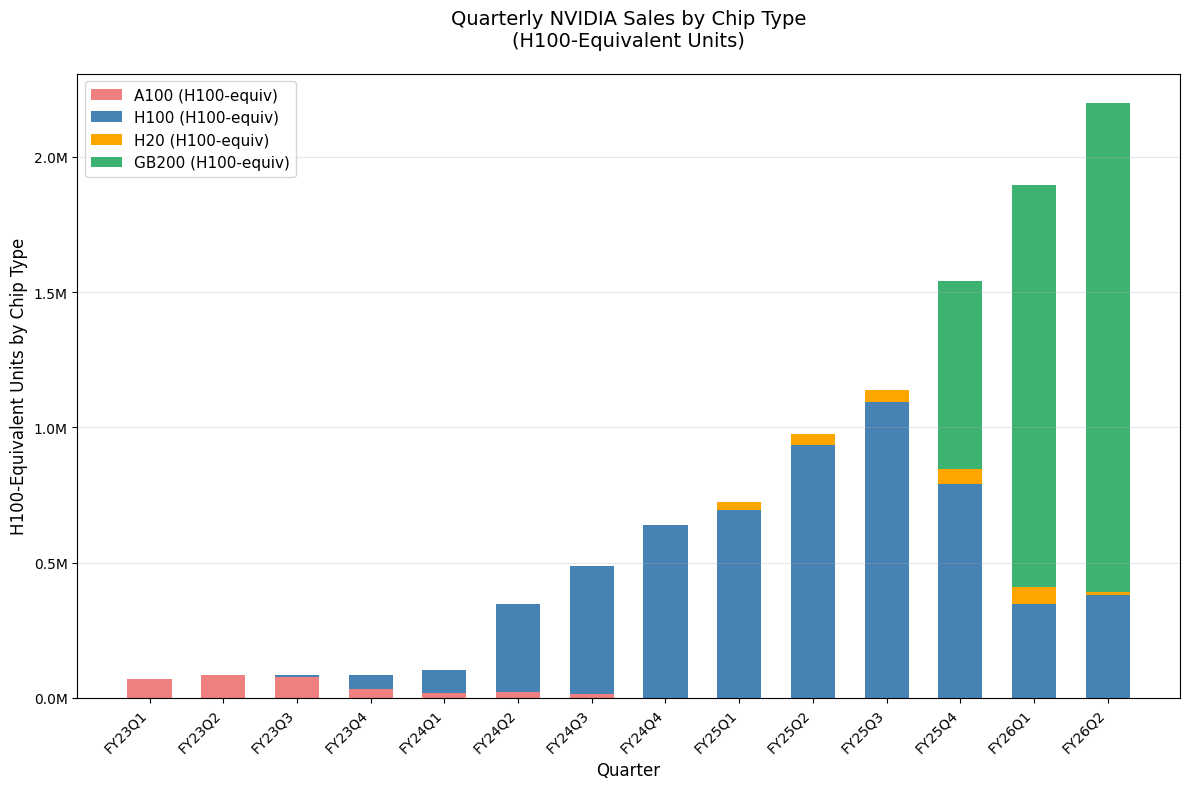

In [ ]:
# Visualization: Quarterly Sales by Chip Type (H100-equivalent units)
# ===================================================================

# to do: add error bars (using H100-eq total?)

# Prepare data for quarterly chart
quarters = quarterly_chip_quantities.index.tolist()
chip_types = ['A100', 'H100', 'H20', 'GB200']

# Get median values for each chip type, converted to H100-equivalents
chip_data = {}
for chip in chip_types:
    chip_data[chip] = convert_to_h100_equivs(
        chip, 
        quarterly_chip_quantities[f'{chip}_quantity_median'].values
    )

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

# Create stacked bars for each chip type
bottom = np.zeros(len(quarters))
colors = {'A100': 'lightcoral', 'H100': 'steelblue', 'H20': 'orange', 'GB200': 'mediumseagreen'}

for chip in chip_types:
    ax.bar(x, chip_data[chip], width, label=f'{chip} (H100-equiv)', 
           bottom=bottom, color=colors[chip])
    bottom += chip_data[chip]

# Add line showing total H100-equivalents per quarter
# totals = quarterly_median_sales['Total_H100_equiv'].values
# ax2 = ax.twinx()
# ax2.plot(x, totals, 'ko-', linewidth=2, markersize=6, label='Total H100-equiv')
# ax2.set_ylabel('Total H100-Equivalent Units', fontsize=12)
# ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Formatting
ax.set_ylabel('H100-Equivalent Units by Chip Type', fontsize=12)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Quarterly NVIDIA Sales by Chip Type\n(H100-Equivalent Units)', 
             fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(quarters, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.grid(True, alpha=0.3, axis='y')

# Combine legends
lines1, labels1 = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax.legend(lines1 + lines2, labels1 + labels2, fontsize=11, loc='upper left')
ax.legend(lines1, labels1, fontsize=11, loc='upper left')

plt.tight_layout()
plt.show()

# Nvidia sales by company

## Aggregate Nvidia sales to Big 4 hyperscalers

In [ ]:
# Company market share estimates (as % of Nvidia's data center revenue)
COMPANY_SHARES = {
    'Microsoft': (0.16, 0.26),
    'Meta': (0.09, 0.14),
    'Alphabet': (0.07, 0.11),
    'Amazon': (0.07, 0.11),
}

# dc_share_of_total_revenue = CHIP_ECONOMICS['dc_share_of_total_revenue']

# Calculate each company's share of Nvidia chips
company_results = {}
company_samples = {}

# Store the squigglepy distributions for subtraction
company_distributions = {}

# US hyperscaler scaling factors
# US companies do not buy H20s, which made up 7% of Nvidia's data center sales
# H20s are only ~1/3 as cost-effective, so US company share of compute-weighted chips should be inflated by 5%
H20_factor = 1.05

# hyperscaler_discount = sq_distribution(0.03, 0.1, lclip = 0)
# hyperscalers likely receive a ~5% discount (relative to overall market average, not relative to small buyers)
# since hyperscalers are ~50% of sales, a 5% discount means their share of units would be ~5% larger than other buyers
# or ~51.2% of units. So an x% discount increases hyperscaler sales by about x/2%
hyperscaler_factor = 1.025

for company, share_range in COMPANY_SHARES.items():
    # Company's share of total Nvidia revenue
    company_share = sq_distribution(*share_range) * H20_factor * hyperscaler_factor

    # Calculate company allocations in H100-equivalent based on their share of datacenter revenue
    # This assumes that hyperscaler customers aren't just buying chips:
    # they are also buying datacenter networking equipment at a similar ratio as the average Nvidia datacenter customer
    company_h100_equivs = company_share * total_h100_equivs
    samples = company_h100_equivs @ 10000

    company_samples[company] = samples
    company_distributions[company] = company_h100_equivs
    company_results[company] = print_percentile_results(samples, f"{company} H100-Equivalents")

# Calculate "Other" category by subtracting each company from total
other_companies = (total_h100_equivs -
                  company_distributions['Microsoft'] -
                  company_distributions['Meta'] -
                  company_distributions['Alphabet'] -
                  company_distributions['Amazon'])

other_samples = other_companies @ 10000
company_samples['Other'] = other_samples
company_results['Other'] = print_percentile_results(other_samples, "Other Companies H100-Equivalents")

Microsoft H100-Equivalents:
  25: 2,023,255
  50: 2,310,724
  75: 2,631,484
Meta H100-Equivalents:
  25: 1,120,028
  50: 1,264,787
  75: 1,430,749
Alphabet H100-Equivalents:
  25: 876,165
  50: 989,618
  75: 1,116,749
Amazon H100-Equivalents:
  25: 877,132
  50: 993,307
  75: 1,122,176
Other Companies H100-Equivalents:
  25: 4,357,589
  50: 4,866,867
  75: 5,378,910


In [81]:
COMPANY_SHARES

{'Microsoft': (0.16, 0.26),
 'Meta': (0.09, 0.14),
 'Alphabet': (0.07, 0.11),
 'Amazon': (0.07, 0.11)}

## Nvidia H100 Equivalents by Company and Quarter

In [85]:
# Calculate H100 Equivalents by Company and Quarter
# ==================================================

# This analysis breaks down chip purchases by company across all quarters
# converting each company's share of each chip type to H100-equivalent units

chip_types = ['A100', 'H100', 'H20', 'GB200']
companies = list(COMPANY_SHARES.keys())
n_samples = 10000

# Initialize results dictionary: company -> quarter -> h100_equivs distribution
company_quarterly_h100_equivs = {company: {} for company in [*companies, 'Other']}

print("Calculating H100-Equivalents by Company and Quarter")
print("=" * 60)

# Iterate through each quarter
for quarter in quarterly_chip_quantities.index:
    print(f"\n{quarter}:")
    
    # Calculate total H100-equivs for this quarter across all chip types
    quarter_total_h100_samples = np.zeros(n_samples)
    
    # For each chip type, sample and convert to H100-equivalents
    chip_distributions = {}
    for chip_type in chip_types:
        dist_key = f'{chip_type}_quantity_dist'
        chip_dist = quarterly_chip_quantities.loc[quarter, dist_key]
        
        if chip_dist is not None:
            # Sample from the distribution
            chip_samples = chip_dist @ n_samples
            
            # Convert to H100-equivalents
            h100_equiv_samples = convert_to_h100_equivs(chip_type, chip_samples)
            
            # Store the samples for this chip type
            chip_distributions[chip_type] = h100_equiv_samples
            quarter_total_h100_samples += h100_equiv_samples
        else:
            chip_distributions[chip_type] = np.zeros(n_samples)
    
    # Initialize non-big-4 h100 equivs for this quarter as the overall total
    other_quarter_h100_equivs = chip_distributions['A100'] + chip_distributions['H100'] + chip_distributions['H20'] + chip_distributions['GB200']
    # total_h100_equivs
    
    # Now calculate each company's share
    # To do: there's an issue with sampling shares independently across quarters, leads to the sum of a company's purchases across
    # quarters to be too narrow (because presumably uncertainty in company share is correlated over time)
    for company in companies:
        # Sample company's share of total Nvidia revenue

        company_share = sq_distribution(*COMPANY_SHARES[company]) * hyperscaler_factor
        
        # Sample the distribution to get samples
        # company_dc_share = company_share_of_total / dc_share_of_total_revenue

        company_share_samples = company_share @ n_samples
        
        # US companies don't buy H20s, so we redistribute their H20 "share" 
        # to H100s with a cost-effectiveness adjustment
        # H100 is ~6.7x more powerful than H20 while costing ~2x as much,
        # so it is ~3.3x more cost-effective
        if company in ['Microsoft', 'Meta', 'Alphabet', 'Amazon']:
            h20_cost_adjustment = 3.3
            
            company_h100_equivs = (
                company_share_samples * (
                    chip_distributions['A100'] + 
                    chip_distributions['H100'] + 
                    h20_cost_adjustment * chip_distributions['H20'] +
                    chip_distributions['GB200']
                )
            )

        # Store results
        company_quarterly_h100_equivs[company][quarter] = company_h100_equivs

        # subtract this company's distribution from the total distribution for the quarter
        other_quarter_h100_equivs = other_quarter_h100_equivs - company_h100_equivs

        print_percentile_results(company_h100_equivs, f"{company} {quarter}")

    print_percentile_results(other_quarter_h100_equivs, f"Other {quarter}")
    company_quarterly_h100_equivs['Other'][quarter] = other_quarter_h100_equivs
    


# Calculate totals by company across all quarters
print("\n" + "=" * 60)
print("Total H100-Equivalents by Company (All Quarters)")
print("=" * 60)

for company in [*companies, 'Other']:
    # Sum across all quarters
    all_quarters_samples = sum(company_quarterly_h100_equivs[company].values())
    print_percentile_results(all_quarters_samples, f"Total H100-equivs for {company}")



Calculating H100-Equivalents by Company and Quarter

FY23Q1:
Microsoft FY23Q1:
  25: 12,005
  50: 14,958
  75: 18,749
Meta FY23Q1:
  25: 6,649
  50: 8,218
  75: 10,170
Alphabet FY23Q1:
  25: 5,179
  50: 6,465
  75: 8,052
Amazon FY23Q1:
  25: 5,191
  50: 6,433
  75: 8,023
Other FY23Q1:
  25: 28,568
  50: 34,884
  75: 42,214

FY23Q2:
Microsoft FY23Q2:
  25: 14,762
  50: 17,539
  75: 20,749
Meta FY23Q2:
  25: 8,233
  50: 9,676
  75: 11,276
Alphabet FY23Q2:
  25: 6,442
  50: 7,549
  75: 8,855
Amazon FY23Q2:
  25: 6,455
  50: 7,566
  75: 8,856
Other FY23Q2:
  25: 35,856
  50: 40,828
  75: 46,301

FY23Q3:
Microsoft FY23Q3:
  25: 15,274
  50: 17,861
  75: 20,947
Meta FY23Q3:
  25: 8,451
  50: 9,817
  75: 11,425
Alphabet FY23Q3:
  25: 6,629
  50: 7,714
  75: 8,971
Amazon FY23Q3:
  25: 6,586
  50: 7,682
  75: 8,928
Other FY23Q3:
  25: 36,946
  50: 41,766
  75: 46,956

FY23Q4:
Microsoft FY23Q4:
  25: 15,446
  50: 17,810
  75: 20,650
Meta FY23Q4:
  25: 8,633
  50: 9,853
  75: 11,249
Alphabet FY23

In [ ]:
company_quarterly_h100_equivs

{'Microsoft': {'FY23Q1': array([10482.02424437, 32368.5400721 , 11002.07467336, ...,
         11671.79046213, 17262.80936331, 16020.19987083]),
  'FY23Q2': array([17235.53723884, 12481.54281815, 17821.95511645, ...,
         22502.15601859, 17909.36434826, 19266.54535308]),
  'FY23Q3': array([21910.44151761, 17685.02462524, 12398.87141412, ...,
         14994.96911123, 21221.51238913, 14081.11951457]),
  'FY23Q4': array([14597.35517113, 19882.94632051, 13208.33888657, ...,
         19783.83988589, 18098.41690666, 15134.9786298 ]),
  'FY24Q1': array([21333.78976331, 23520.94754628, 20749.23706967, ...,
         21853.12731182, 18165.4242856 , 17494.85879902]),
  'FY24Q2': array([124967.87238979,  83986.09616918,  69431.32677323, ...,
          59186.96609997,  67647.92206831,  66623.98981363]),
  'FY24Q3': array([ 79073.19404706,  90830.66174475, 107381.357319  , ...,
         103751.97826213,  88918.01604438,  96986.41664706]),
  'FY24Q4': array([117834.40511848, 160843.9951067 , 10916

In [ ]:
# Create a summary DataFrame for easier analysis
company_quarterly_summary = []

for company in companies:
    for quarter in quarterly_revenue_df.index:
        if quarter in company_quarterly_h100_equivs[company]:
            samples = company_quarterly_h100_equivs[company][quarter]
            company_quarterly_summary.append({
                'Company': company,
                'Quarter': quarter,
                'decimal_year': fy_to_decimal_year(quarter),
                'h100_equivs_25th': np.percentile(samples, 25),
                'h100_equivs_median': np.percentile(samples, 50),
                'h100_equivs_75th': np.percentile(samples, 75)
            })

company_quarterly_df = pd.DataFrame(company_quarterly_summary)

print("\nSummary DataFrame (first 20 rows):")
print(company_quarterly_df.head(20))



Summary DataFrame (first 20 rows):
      Company Quarter  decimal_year  h100_equivs_25th  h100_equivs_median  \
0   Microsoft  FY23Q1       2022.32      11574.453515        14353.042848   
1   Microsoft  FY23Q2       2022.57      14376.256550        16833.616105   
2   Microsoft  FY23Q3       2022.82      14633.534642        17055.525935   
3   Microsoft  FY23Q4       2023.07      14365.152668        16531.443749   
4   Microsoft  FY24Q1       2023.32      17101.371324        19746.856985   
5   Microsoft  FY24Q2       2023.57      59790.239368        69730.910550   
6   Microsoft  FY24Q3       2023.82      85286.425935        99928.667293   
7   Microsoft  FY24Q4       2024.07     109973.830384       128244.452500   
8   Microsoft  FY25Q1       2024.32     135525.728749       157896.350799   
9   Microsoft  FY25Q2       2024.57     185111.230793       212532.336157   
10  Microsoft  FY25Q3       2024.82     215832.234084       248781.025450   
11  Microsoft  FY25Q4       2025.07     

## Microsoft time series chart

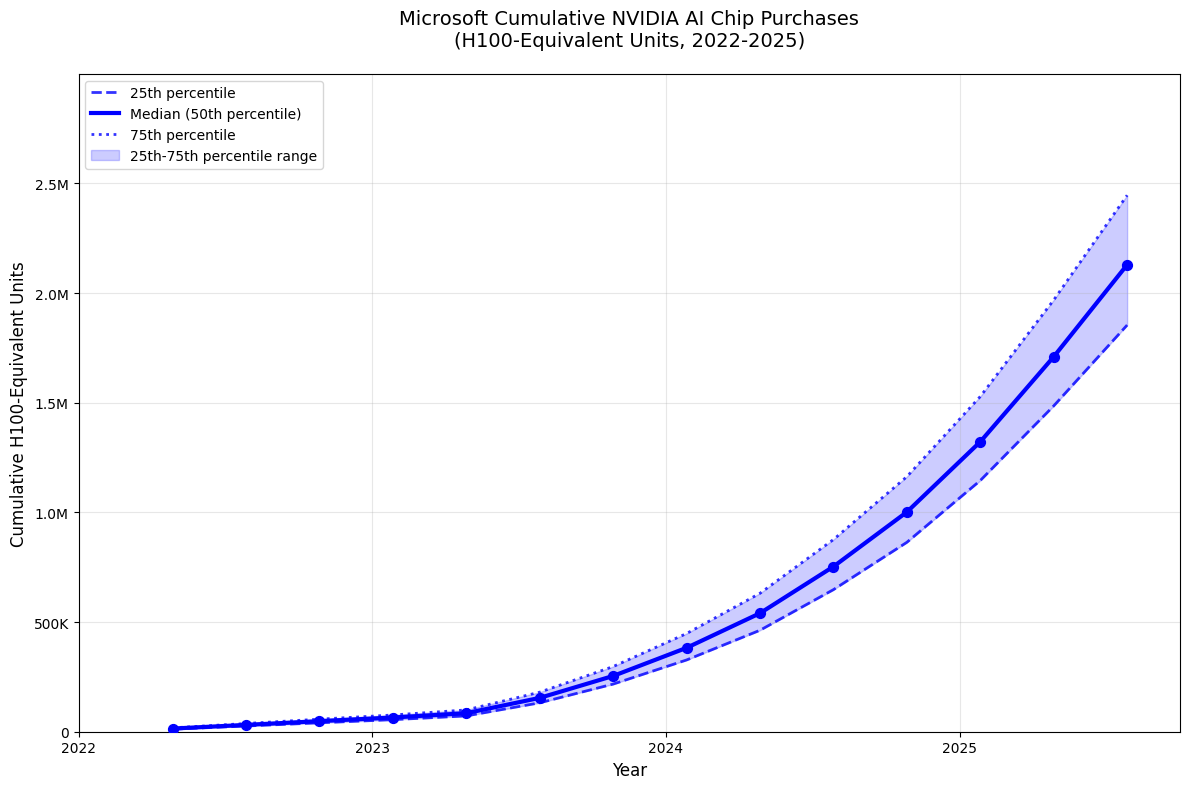

Microsoft H100-equivalent Purchase Timeline:
Quarter         Year     Median Purchase Cumulative Median 25th-75th Range               
FY23Q1          2022.32        14,353       14,353       11,574 -       17,761
FY23Q2          2022.57        16,834       31,187       25,951 -       37,472
FY23Q3          2022.82        17,056       48,242       40,584 -       57,237
FY23Q4          2023.07        16,531       64,774       54,949 -       76,332
FY24Q1          2023.32        19,747       84,520       72,051 -       99,360
FY24Q2          2023.57        69,731      154,251      131,841 -      180,268
FY24Q3          2023.82        99,929      254,180      217,127 -      297,097
FY24Q4          2024.07       128,244      382,425      327,101 -      447,733
FY25Q1          2024.32       157,896      540,321      462,627 -      631,248
FY25Q2          2024.57       212,532      752,853      647,738 -      876,210
FY25Q3          2024.82       248,781    1,001,634      863,570 -    1,163,

In [ ]:
# Microsoft Cumulative Time Series Chart (using new company_quarterly_df)
# ========================================================================

# Filter for Microsoft data only and sort by decimal_year
microsoft_data = company_quarterly_df[company_quarterly_df['Company'] == 'Microsoft'].copy()
microsoft_data = microsoft_data.sort_values('decimal_year')

# Calculate cumulative sums for each percentile
microsoft_data['cumulative_25th'] = microsoft_data['h100_equivs_25th'].cumsum()
microsoft_data['cumulative_median'] = microsoft_data['h100_equivs_median'].cumsum()
microsoft_data['cumulative_75th'] = microsoft_data['h100_equivs_75th'].cumsum()

# Create the time series chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the three percentile lines
ax.plot(microsoft_data['decimal_year'],
        microsoft_data['cumulative_25th'],
        'b--', linewidth=2, label='25th percentile', alpha=0.8)

ax.plot(microsoft_data['decimal_year'],
        microsoft_data['cumulative_median'],
        'b-', linewidth=3, label='Median (50th percentile)')

ax.plot(microsoft_data['decimal_year'],
        microsoft_data['cumulative_75th'],
        'b:', linewidth=2, label='75th percentile', alpha=0.8)

# Fill between 25th and 75th percentiles for uncertainty band
ax.fill_between(microsoft_data['decimal_year'],
                microsoft_data['cumulative_25th'],
                microsoft_data['cumulative_75th'],
                alpha=0.2, color='blue', label='25th-75th percentile range')

# Add markers at quarterly points
ax.scatter(microsoft_data['decimal_year'],
           microsoft_data['cumulative_median'],
           s=50, color='blue', zorder=5)

# Formatting
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cumulative H100-Equivalent Units', fontsize=12)
ax.set_title('Microsoft Cumulative NVIDIA AI Chip Purchases\n(H100-Equivalent Units, 2022-2025)', fontsize=14, pad=20)

# Format y-axis to show values in thousands/millions
def format_thousands(x, p):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x:.0f}'

ax.yaxis.set_major_formatter(plt.FuncFormatter(format_thousands))

# Set x-axis to show years nicely
ax.set_xlim(2022, 2025.75)
ax.set_xticks([2022, 2023, 2024, 2025])
ax.set_ylim(0, 2999999)

# Add grid and legend
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary table
print("Microsoft H100-equivalent Purchase Timeline:")
print("=" * 80)
print(f"{'Quarter':<15} {'Year':<8} {'Median Purchase':<15} {'Cumulative Median':<15} {'25th-75th Range':<30}")
print("=" * 80)
for _, row in microsoft_data.iterrows():
    quarter = row['Quarter']
    year = row['decimal_year']
    median_purchase = row['h100_equivs_median']
    cumulative_25th = row['cumulative_25th']
    cumulative_median = row['cumulative_median']
    cumulative_75th = row['cumulative_75th']
    print(f"{quarter:<15} {year:<8.2f} {median_purchase:>12,.0f} {cumulative_median:>12,.0f} {cumulative_25th:>12,.0f} - {cumulative_75th:>12,.0f}")
print("=" * 80)

In [ ]:
microsoft_data.to_csv('microsoft_data.csv')

## CoreWeave, Oracle, and xAI


### CoreWeave

In [86]:
H100_share_2024 = (0.6, 0.8)
GPU_count_2024 = 250000

COREWEAVE_DATA = {
    # GPU counts from S-1 filing
    'gpus_2024_end': 250_000,

    # GPU mix estimates for installed base at end of 2024
    'hopper_share_2024': (0.6, 0.8),  # 60-80% H100s, rest A100s

    # parameters for estimating data center power of GPUs beyond the 2024 installed base (including hypothetical capacity for GPUs waiting to be installed)
    # 55 MW installed in Q1 and Q2 2025 on average, 72 MW installed per quarter in 2024
    # and CoreWeave's capex is generally ramping up
    'gpu_power_per_quarter': (50, 100),
    # hard variable to name: this represents the number of "quarters' worth" of GPUs CoreWeave has purchased beyond the 2024 installed base.
    # which incorporates uncertainty over the time delay between taking delivery of GPUs and installation in a data center
    'quarters_backlog': (2, 4),

    'h100_datacenter_power_w': (1400, 1700),    # H100 power capacity with PUE overhead
    'NVL72_power_w': (120000, 132000),  # server power rating for NVL72 (72 B200s)
    'NVL72_overhead_factor': (1.1, 1.7),   # PUE overhead (SemiAnalysis estimates 1.35x)
    # the lower end of this range is based on the three Nvidia quarters ending April 2025. The upper is shifted by one quarter
    # REVISIT AFTER NVDA EARNINGS
    'blackwell_share': (0.33, 0.6)
}

n_samples = 10000

# Installed base at end of 2024: 250k GPUs
installed_base = COREWEAVE_DATA['gpus_2024_end']

# Mix of installed base (Hopper vs older generation)
hopper_share_installed = sq_distribution(*COREWEAVE_DATA['hopper_share_2024'], rclip = 1)

# Installed base H100-equivalents
hopper_count = installed_base * hopper_share_installed
a100_count = installed_base * (1 - hopper_share_installed)

# Convert A100s to H100-equivalents (A100 is 312 TFLOPS vs H100's 989 TFLOPS)
a100_h100_equiv = a100_count * (CHIP_SPECS['A100'] / CHIP_SPECS['H100'])
installed_base_h100_equiv = hopper_count + a100_h100_equiv

samples = installed_base_h100_equiv @ n_samples

print_percentile_results(samples, "CoreWeave H100-equivs at end of 2024")

gpu_power_per_quarter = sq_distribution(*COREWEAVE_DATA['gpu_power_per_quarter']) * 1e6
quarters_backlog = sq_distribution(*COREWEAVE_DATA['quarters_backlog'])

new_gpu_power_2025 = gpu_power_per_quarter * quarters_backlog

blackwell_share = sq_distribution(*COREWEAVE_DATA['blackwell_share'], lclip = 0, rclip = 1)

h100_dc_power_w = sq_distribution(*COREWEAVE_DATA['h100_datacenter_power_w'])
NVL72_power_w = sq_distribution(*COREWEAVE_DATA['NVL72_power_w'])
NVL72_overhead_factor = sq_distribution(*COREWEAVE_DATA['NVL72_overhead_factor'])

gb200_dc_power_w = NVL72_power_w * NVL72_overhead_factor / 72
gb200_power_samples = gb200_dc_power_w @ n_samples
print_percentile_results(gb200_power_samples, "GB200 power capacity in a data center (W)")

# Estimate power and GPU count by model. Assumes all non-Blackwell chips in 2025 are H100
blackwell_power_w = new_gpu_power_2025 * blackwell_share
h100_power_w = new_gpu_power_2025 * (1 - blackwell_share)
cw_blackwell_2025 = blackwell_power_w / gb200_dc_power_w
cw_hopper_2025 = h100_power_w / h100_dc_power_w

blackwell_h100_equiv = cw_blackwell_2025 * (CHIP_SPECS['GB200'] / CHIP_SPECS['H100'])
total_coreweave_h100_equiv = installed_base_h100_equiv + cw_hopper_2025 + blackwell_h100_equiv


coreweave_samples = total_coreweave_h100_equiv @ n_samples
print_percentile_results(coreweave_samples, "Total CoreWeave H100-equivs as of July 2025")

CoreWeave H100-equivs at end of 2024:
  25: 183,709
  50: 197,627
  75: 211,592
GB200 power capacity in a data center (W):
  25: 2,125
  50: 2,388
  75: 2,687
Total CoreWeave H100-equivs as of July 2025:
  25: 333,887
  50: 371,271
  75: 417,435


{25: 333887, 50: 371271, 75: 417435}

In [91]:
coreweave_samples

array([380018.49431675, 259035.80282308, 384579.32860903, ...,
       382770.90157606, 456318.30105185, 337659.77521316])

# Integrating CoreWeave and H20 with "Other" bar

In [87]:
other_samples

print_percentile_results(other_samples, "Non-Big 4 hyperscalers")

other_minus_coreweave = other_samples - coreweave_samples

print_percentile_results(other_minus_coreweave, "Non-Big 4 hyperscalers, non-CoreWeave")

Non-Big 4 hyperscalers:
  25: 4,357,589
  50: 4,866,867
  75: 5,378,910
Non-Big 4 hyperscalers, non-CoreWeave:
  25: 3,976,481
  50: 4,487,809
  75: 5,001,320


{25: 3976481, 50: 4487809, 75: 5001320}

In [88]:
# Shuffle to decorrelate (approximate independence)
np.random.shuffle(other_samples)
np.random.shuffle(coreweave_samples)
other_minus_coreweave_shuffled = other_samples - coreweave_samples

# essentially no difference
print_percentile_results(other_minus_coreweave_shuffled, "Non-Big 4 hyperscalers, non-CoreWeave")

Non-Big 4 hyperscalers, non-CoreWeave:
  25: 3,970,254
  50: 4,486,291
  75: 5,002,392


{25: 3970254, 50: 4486291, 75: 5002392}

In [89]:
company_results

{'Microsoft': {25: 2023255, 50: 2310724, 75: 2631484},
 'Meta': {25: 1120028, 50: 1264787, 75: 1430749},
 'Alphabet': {25: 876165, 50: 989618, 75: 1116749},
 'Amazon': {25: 877132, 50: 993307, 75: 1122176},
 'Other': {25: 4357589, 50: 4866867, 75: 5378910}}

In [90]:
company_results['CoreWeave'] = print_percentile_results(coreweave_samples, "CoreWeave H100-Equivalents")
company_results['Other'] = print_percentile_results(other_minus_coreweave, f"{company} H100-Equivalents")

CoreWeave H100-Equivalents:
  25: 333,887
  50: 371,271
  75: 417,435
Other H100-Equivalents:
  25: 3,976,481
  50: 4,487,809
  75: 5,001,320


In [92]:
other_minus_h20 = other_minus_coreweave - h20_h100_samples
company_results['Other'] = print_percentile_results(other_minus_h20)
company_results['H20'] = print_percentile_results(h20_h100_samples)


Percentiles:
  25: 3,735,191
  50: 4,248,466
  75: 4,762,796
Percentiles:
  25: 231,049
  50: 239,152
  75: 247,739


# TPU estimates

In [ ]:
# Google TPU Analysis
# ===================

# Core chip performance specifications (TFLOPS for ML workloads)
CHIP_SPECS = {
    'A100': 312,      # NVIDIA A100
    'H100': 989,      # NVIDIA H100 (baseline for equivalence)
    'H20': 148,       # Export-restricted chip for China
    'B200': 2250,     # Blackwell B200/GB200
    'TPUv3': 123,     # Google TPU v3
    'TPUv4': 275,     # Google TPU v4
    'TPUv4i': 138,    # Google TPU v4i (inference optimized)
    'TPUv5e': 197,    # Google TPU v5e
    'TPUv5p': 459,    # Google TPU v5p, used to train Gemini 2.5
    'TPUv6e': 918
    #TPUv6p does not exist, v6e is the only v6 variant to be announced
    #TPUv7 (Ironwood) was announced recently and most likely not deployed at scale yet
}

# TPU deployment estimates from TechInsights and public hints
TPU_ESTIMATES = {
    # TechInsights report: 1.5M TPUs in 2022 ±20% uncertainty
    'tpu_count_2022': 1_500_000,
    'techinsights_uncertainty': 1.2,

    # Estimated production for subsequent years
    'tpu_count_2023': 2_000_000,
    'tpu_count_2024_h1': (1_000_000, 1_500_000),  # H1 2024 production
    #'tpu_count_2024': (2_000_000, 3_000_000),  # Extrapolated 2024 production
    #'tpu_count_2025_q1': (500_000, 1_000_000),  # Extrapolated 2025 production

    # Mix estimates for deployed TPU generations
    'v3_proportion_2022': (0.2, 0.6),      # 20-60% v3, rest v4
    'v4i_proportion_of_v4': (0.1, 0.9),    # 10-90% of v4s are v4i
    'v4_proportion_2023': (0.5, 0.8),      # 50-80% v4, rest v5
    'v5_proportion_2024': (1, 1),          # assume Google switched over to v5 by 2024
    'v5e_proportion_of_v5': (0.5, 0.9),    # 50-90% of v5s are v5e

    # Power-based estimate (Google's >1GW AI infrastructure)
    'google_capacity_mw': (1000, 2000),    # 1-2 GW installed
    'google_pue': 1.1,                     # Power Usage Effectiveness
    'tpuv4_power_watts': 275,             # TPUv4 power consumption
    'server_to_chip_power_ratio': 1.96,    # Based on H100 server ratios
}

def estimate_tpu_h100_equivalents_by_year():
    """Estimate TPU deployments converted to H100-equivalents for each year."""

    # 2022 TPUs (based on TechInsights report)
    tpu_count_22 = generate_lognormal_from_percentiles(
        TPU_ESTIMATES['tpu_count_2022'] / TPU_ESTIMATES['techinsights_uncertainty'],
        TPU_ESTIMATES['tpu_count_2022'] * TPU_ESTIMATES['techinsights_uncertainty'],
        20, 80
    )

    # Mix of TPU generations in 2022
    v3_prop_22 = np.clip(generate_lognormal_from_percentiles(*TPU_ESTIMATES['v3_proportion_2022'], 20, 80), 0, 1)
    v4i_prop = np.clip(generate_lognormal_from_percentiles(*TPU_ESTIMATES['v4i_proportion_of_v4'], 10, 90), 0, 1)

    # Average TFLOPS for 2022 TPUs
    tflops_22 = (v3_prop_22 * CHIP_SPECS['TPUv3'] +
                 (1 - v3_prop_22) * v4i_prop * CHIP_SPECS['TPUv4i'] +
                 (1 - v3_prop_22) * (1 - v4i_prop) * CHIP_SPECS['TPUv4'])

    # Shuffle to decorrelate (approximate independence)
    np.random.shuffle(tflops_22)
    np.random.shuffle(tpu_count_22)

    h100_equiv_22 = (tflops_22 * tpu_count_22) / CHIP_SPECS['H100']

    # 2023 TPUs
    tpu_count_23 = generate_lognormal_from_percentiles(
        TPU_ESTIMATES['tpu_count_2023'] / TPU_ESTIMATES['techinsights_uncertainty'],
        TPU_ESTIMATES['tpu_count_2023'] * TPU_ESTIMATES['techinsights_uncertainty'],
        20, 80
    )

    v4_prop_23 = np.clip(generate_lognormal_from_percentiles(*TPU_ESTIMATES['v4_proportion_2023'], 20, 80), 0, 1)
    v5e_prop = np.clip(generate_lognormal_from_percentiles(*TPU_ESTIMATES['v5e_proportion_of_v5'], 20, 80), 0, 1)

    tflops_23 = (v4_prop_23 * v4i_prop * CHIP_SPECS['TPUv4i'] +
                 v4_prop_23 * (1 - v4i_prop) * CHIP_SPECS['TPUv4'] +
                 (1 - v4_prop_23) * v5e_prop * CHIP_SPECS['TPUv5e'] +
                 (1 - v4_prop_23) * (1 - v5e_prop) * CHIP_SPECS['TPUv5p'])

    np.random.shuffle(tflops_23)
    np.random.shuffle(tpu_count_23)

    h100_equiv_23 = (tflops_23 * tpu_count_23) / CHIP_SPECS['H100']

    # 2024 TPUs (H1 only)
    tpu_count_24 = generate_lognormal_from_percentiles(*TPU_ESTIMATES['tpu_count_2024_h1'], 20, 80)
    tflops_24 = v5e_prop * CHIP_SPECS['TPUv5e'] + (1 - v5e_prop) * CHIP_SPECS['TPUv5p']

    np.random.shuffle(tflops_24)
    np.random.shuffle(tpu_count_24)

    h100_equiv_24 = (tflops_24 * tpu_count_24) / CHIP_SPECS['H100']

    return h100_equiv_22, h100_equiv_23, h100_equiv_24

def estimate_tpu_from_power():
    """Alternative TPU estimate based on Google's disclosed power capacity."""
    capacity_mw = generate_lognormal_from_percentiles(*TPU_ESTIMATES['google_capacity_mw'], 10, 90)

    # Convert power to TPU count
    total_power_per_tpu = (TPU_ESTIMATES['tpuv4_power_watts'] *
                          TPU_ESTIMATES['google_pue'] *
                          TPU_ESTIMATES['server_to_chip_power_ratio'])

    tpu_count = capacity_mw * 1e6 / total_power_per_tpu

    # Convert to H100-equivalents using TPUv4 performance
    h100_equiv = tpu_count * CHIP_SPECS['TPUv4'] / CHIP_SPECS['H100']

    return h100_equiv

# Run TPU analyses
print("TPU Analysis Results:")
print("=" * 40)

h100_equiv_22, h100_equiv_23, h100_equiv_24 = estimate_tpu_h100_equivalents_by_year()

print_percentile_results(h100_equiv_22, "2022 TPUs (H100-equivalents)")
print_percentile_results(h100_equiv_23, "2023 TPUs (H100-equivalents)")
print_percentile_results(h100_equiv_24, "2024 TPUs (H100-equivalents)")

# Total from production-based estimate
total_production_tpus = h100_equiv_22 + h100_equiv_23 + h100_equiv_24
print_percentile_results(total_production_tpus, "Total TPUs from Production Estimate")

# Power-based estimate
power_tpus = estimate_tpu_from_power()
print_percentile_results(power_tpus, "TPUs from Power-Based Estimate")

# Combine both estimates
combined_tpu_samples = np.concatenate([total_production_tpus, power_tpus])
tpu_results = print_percentile_results(combined_tpu_samples, "Combined TPU Estimate (H100-equivalents)")

TPU Analysis Results:
2022 TPUs (H100-equivalents):
  25: 220,378
  50: 271,228
  75: 330,003
2023 TPUs (H100-equivalents):
  25: 406,581
  50: 487,684
  75: 578,780
2024 TPUs (H100-equivalents):
  25: 274,268
  50: 341,298
  75: 418,711
Total TPUs from Production Estimate:
  25: 1,005,928
  50: 1,124,247
  75: 1,255,012
TPUs from Power-Based Estimate:
  25: 552,240
  50: 661,488
  75: 790,980
Combined TPU Estimate (H100-equivalents):
  25: 660,926
  50: 914,727
  75: 1,134,695


In [ ]:
# sensitivity analysis on TPU chip-based estimate

# # TPU deployment estimates from TechInsights and public hints
# TPU_ESTIMATES = {
#     # TechInsights report: 1.5M TPUs in 2022 ±20% uncertainty
#     'tpu_count_2022': 1_500_000,
#     'techinsights_uncertainty': 1.2,

#     # Estimated production for subsequent years
#     'tpu_count_2023': 2_000_000,
#     'tpu_count_2024_h1': (1_000_000, 1_500_000),  # H1 2024 production
#     #'tpu_count_2024': (2_000_000, 3_000_000),  # Extrapolated 2024 production
#     #'tpu_count_2025_q1': (500_000, 1_000_000),  # Extrapolated 2025 production

#     # Mix estimates for deployed TPU generations
#     'v3_proportion_2022': (0.2, 0.6),      # 20-60% v3, rest v4
#     'v4i_proportion_of_v4': (0.5, 0.9),    # 10-90% of v4s are v4i
#     'v4_proportion_2023': (0.5, 0.8),      # 50-80% v4, rest v5
#     'v5_proportion_2024': (1, 1),          # assume Google switched over to v5 by 2024
#     'v5e_proportion_of_v5': (0.5, 0.9),    # 50-90% of v5s are v5e

#     # Power-based estimate (Google's >1GW AI infrastructure)
#     'google_capacity_mw': (1000, 2000),    # 1-2 GW installed
#     'google_pue': 1.1,                     # Power Usage Effectiveness
#     'tpuv4_power_watts': 275,             # TPUv4 power consumption
#     'server_to_chip_power_ratio': 1.96,    # Based on H100 server ratios
# }


# increase v3 share in 2022 from 20-60% to 50-90%
TPU_ESTIMATES['v3_proportion_2022'] = (0.5, 0.9)
# dramatically increase v4i proportion from 10-90% to 60-90%
TPU_ESTIMATES['v4i_proportion_of_v4'] = (0.6, 0.9)
# cut 2024 estimate in half
TPU_ESTIMATES['tpu_count_2024_h1'] = (500_000, 700_000)

h100_equiv_22, h100_equiv_23, h100_equiv_24 = estimate_tpu_h100_equivalents_by_year()

print_percentile_results(h100_equiv_22, "2022 TPUs (H100-equivalents)")
print_percentile_results(h100_equiv_23, "2023 TPUs (H100-equivalents)")
print_percentile_results(h100_equiv_24, "2024 TPUs (H100-equivalents)")

total_production_tpus = h100_equiv_22 + h100_equiv_23 + h100_equiv_24
print_percentile_results(total_production_tpus, "Total TPUs from Production Estimate")

# overall, median estimate goes down from 1.1M to 800k. So it's not that sensitive to our assumptions
# didn't change the assumption about v5 being 100% of 2024 though

2022 TPUs (H100-equivalents):
  25: 178,782
  50: 208,850
  75: 244,324
2023 TPUs (H100-equivalents):
  25: 350,184
  50: 416,371
  75: 497,342
2024 TPUs (H100-equivalents):
  25: 135,262
  50: 164,519
  75: 198,396
Total TPUs from Production Estimate:
  25: 722,463
  50: 804,310
  75: 898,046


{25: 722463, 50: 804310, 75: 898046}

In [ ]:
# Combined Results and Analysis
# =============================

# Calculate Alphabet's total (NVIDIA + TPU)
alphabet_nvidia_samples = company_samples['Alphabet']
alphabet_tpu_samples = np.random.choice(combined_tpu_samples, len(alphabet_nvidia_samples))
alphabet_total_samples = alphabet_nvidia_samples + alphabet_tpu_samples

print("Final Results Summary:")
print("=" * 50)

print("\nNVIDIA H100-Equivalent Sales by Company:")
for company in ['Microsoft', 'Meta', 'Alphabet', 'Amazon', 'Other']:
    results = company_results[company]
    print(f"  {company}: {results[25]:,} - {results[75]:,} (median: {results[50]:,})")

print(f"\nGoogle TPUs (H100-equivalents): {tpu_results[25]:,} - {tpu_results[75]:,} (median: {tpu_results[50]:,})")

alphabet_total_results = print_percentile_results(alphabet_total_samples, "Alphabet Total (NVIDIA + TPUs)")

# Calculate market share of "Other" companies
other_fraction_samples = company_samples['Other'] / (total_samples + np.random.choice(combined_tpu_samples, len(total_samples)))
other_fraction_results = sq.get_percentiles(other_fraction_samples, percentiles=[25, 50, 75])

print(f"\n'Other' companies represent {other_fraction_results[25]:.1%} - {other_fraction_results[75]:.1%} of total market")
print(f"(median: {other_fraction_results[50]:.1%})")

Final Results Summary:

NVIDIA H100-Equivalent Sales by Company:
  Microsoft: 1,980,672 - 2,355,676 (median: 2,162,227)
  Meta: 933,843 - 1,295,162 (median: 1,099,074)
  Alphabet: 673,038 - 977,624 (median: 811,433)
  Amazon: 678,808 - 974,587 (median: 813,322)
  Other: 3,779,424 - 4,624,291 (median: 4,199,291)

Google TPUs (H100-equivalents): 660,926 - 1,134,695 (median: 914,727)
Alphabet Total (NVIDIA + TPUs):
  25: 1,484,878
  50: 1,755,676
  75: 2,008,406

'Other' companies represent 40.8% - 49.1% of total market
(median: 45.1%)


# Visualizations

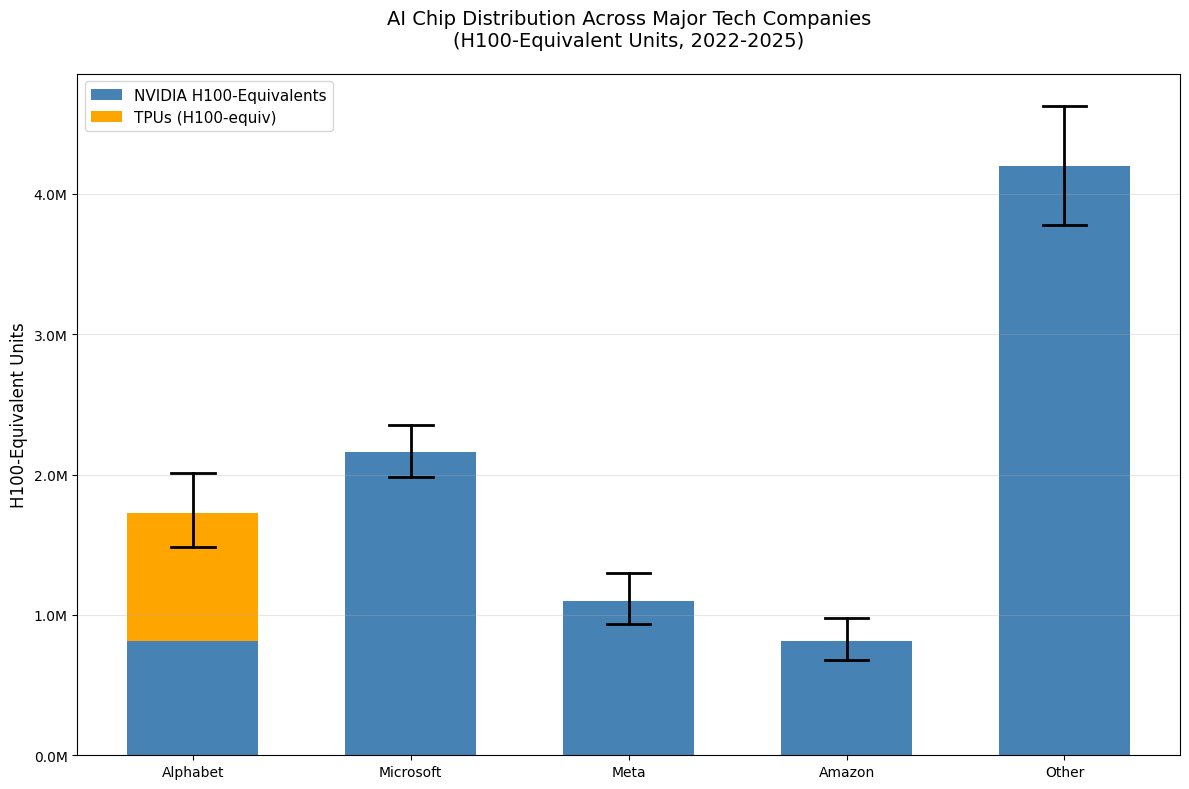


Visualization Notes:
- Error bars show 25th-75th percentile range
- Alphabet includes both NVIDIA chips and TPUs
- All values converted to H100-equivalent compute units
- Based on NVIDIA revenue FY2023-FY2025 and industry estimates


In [ ]:
# Visualization
# =============

# Prepare data for plotting
companies = ['Alphabet', 'Microsoft', 'Meta', 'Amazon', 'Other']
nvidia_medians = [company_results[company][50] for company in companies]
nvidia_25th = [company_results[company][25] for company in companies]
nvidia_75th = [company_results[company][75] for company in companies]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(companies))
width = 0.6

# Create NVIDIA bars
nvidia_bars = ax.bar(x, nvidia_medians, width, label="NVIDIA H100-Equivalents", color='steelblue')

# Add TPU bar for Alphabet (stacked on NVIDIA)
alphabet_idx = companies.index('Alphabet')
tpu_median = tpu_results[50]
ax.bar(alphabet_idx, tpu_median, width, bottom=nvidia_medians[alphabet_idx],
       label="TPUs (H100-equiv)", color='orange')

# Add confidence intervals
for i, company in enumerate(companies):
    if company != 'Alphabet':
        # Regular confidence intervals for NVIDIA-only companies
        bar_width = width / 6
        ax.plot([i - bar_width, i + bar_width], [nvidia_25th[i], nvidia_25th[i]], 'k-', linewidth=2)
        ax.plot([i - bar_width, i + bar_width], [nvidia_75th[i], nvidia_75th[i]], 'k-', linewidth=2)
        ax.plot([i, i], [nvidia_25th[i], nvidia_75th[i]], 'k-', linewidth=2)
    else:
        # Confidence interval for Alphabet total (NVIDIA + TPU)
        total_25th = alphabet_total_results[25]
        total_75th = alphabet_total_results[75]
        bar_width = width / 6
        ax.plot([i - bar_width, i + bar_width], [total_25th, total_25th], 'k-', linewidth=2)
        ax.plot([i - bar_width, i + bar_width], [total_75th, total_75th], 'k-', linewidth=2)
        ax.plot([i, i], [total_25th, total_75th], 'k-', linewidth=2)

# Formatting
ax.set_ylabel('H100-Equivalent Units', fontsize=12)
ax.set_title('AI Chip Distribution Across Major Tech Companies\n(H100-Equivalent Units, 2022-2025)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(companies)
ax.legend(fontsize=11)

# Format y-axis to show values in millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Add grid for readability
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nVisualization Notes:")
print("- Error bars show 25th-75th percentile range")
print("- Alphabet includes both NVIDIA chips and TPUs")
print("- All values converted to H100-equivalent compute units")
print("- Based on NVIDIA revenue FY2023-FY2025 and industry estimates")

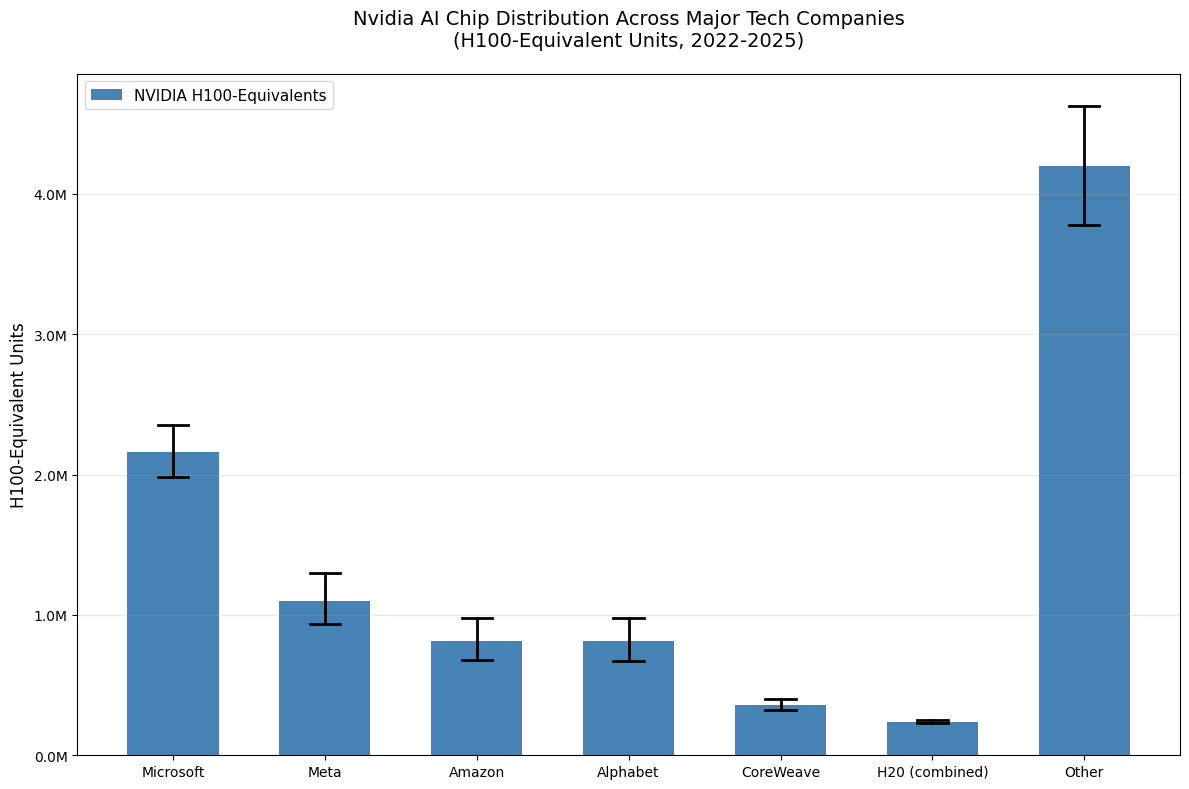


Visualization Notes:
- Error bars show 25th-75th percentile range
- Alphabet includes both NVIDIA chips and TPUs
- All values converted to H100-equivalent compute units
- Based on NVIDIA revenue FY2023-FY2025 and industry estimates


In [ ]:
# version without TPU

# Visualization
# =============

# Prepare data for plotting
companies = [ 'Microsoft', 'Meta', 'Amazon', 'Alphabet',  'CoreWeave', 'H20', 'Other']
nvidia_medians = [company_results[company][50] for company in companies]
nvidia_25th = [company_results[company][25] for company in companies]
nvidia_75th = [company_results[company][75] for company in companies]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(companies))
width = 0.6

# Create NVIDIA bars
nvidia_bars = ax.bar(x, nvidia_medians, width, label="NVIDIA H100-Equivalents", color='steelblue')

# Add TPU bar for Alphabet (stacked on NVIDIA)
# alphabet_idx = companies.index('Alphabet')
# tpu_median = tpu_results[50]
# ax.bar(alphabet_idx, tpu_median, width, bottom=nvidia_medians[alphabet_idx],
#        label="TPUs (H100-equiv)", color='orange')

# Add confidence intervals
for i, company in enumerate(companies):
    bar_width = width / 6
    ax.plot([i - bar_width, i + bar_width], [nvidia_25th[i], nvidia_25th[i]], 'k-', linewidth=2)
    ax.plot([i - bar_width, i + bar_width], [nvidia_75th[i], nvidia_75th[i]], 'k-', linewidth=2)
    ax.plot([i, i], [nvidia_25th[i], nvidia_75th[i]], 'k-', linewidth=2)


# Formatting
ax.set_ylabel('H100-Equivalent Units', fontsize=12)
ax.set_title('Nvidia AI Chip Distribution Across Major Tech Companies\n(H100-Equivalent Units, 2022-2025)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels([ 'Microsoft', 'Meta', 'Amazon', 'Alphabet',  'CoreWeave', 'H20 (combined)', 'Other'])
ax.legend(fontsize=11)

# Format y-axis to show values in millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Add grid for readability
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nVisualization Notes:")
print("- Error bars show 25th-75th percentile range")
print("- All values converted to H100-equivalent compute units")
print("- Based on NVIDIA revenue FY2023-FY2025 and industry estimates")